<a href="https://colab.research.google.com/github/dinakeshvari/Alcoholic_CNN_Classification/blob/main/Project02_DS04_S02_WordEmbedding_RezaShokrzad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📰 News Article Similarity Analysis using NLP 🧠📊

## 🎯 Objective
This notebook explores text similarity among news articles using NLP techniques. We will:

✅ Convert text into numerical vectors using pre-trained **GloVe embeddings**.  
✅ Reduce dimensionality for visualization using **PCA**.  
✅ Apply **K-Means clustering** to group similar news articles.  

---

## 🔍 Why GloVe?
GloVe (**Global Vectors for Word Representation**) provides **dense vector embeddings** trained on a large corpus, allowing us to capture the **semantic meaning** of words efficiently. 🏆✨  

Using GloVe, we can **transform text into meaningful numerical representations** for further processing and clustering. 🚀📖


In [1]:
# 📥 Import necessary libraries
# ⬇️ Download stopwords for text cleaning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# prevent warning
import warnings
warnings.filterwarnings('ignore')

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# dimensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# ML models and metrics
from sklearn.cluster import KMeans


In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize NLP tools
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## 📊 Data Overview
The dataset consists of news articles with the following columns:

📰 **title**: The headline of the news article.  
📄 **content**: The full text of the article.  

🎯 Our goal is to **analyze the similarity between articles** and **group them into clusters** for better understanding. 🔍🤖  


In [4]:

# download the dataset
!wget https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv


--2025-04-26 11:39:02--  https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18236066 (17M) [text/plain]
Saving to: ‘news_articles.csv’

news_articles.csv   100%[===================>]  17.39M  --.-KB/s    in 0.1s    

2025-04-26 11:39:03 (123 MB/s) - ‘news_articles.csv’ saved [18236066/18236066]



In [5]:

# Load dataset
df = pd.read_csv('news_articles.csv')
# Display basic dataset information
df.head()

topic                                           headline  \
0  entertainment  Will Smith Joins Diplo And Nicky Jam For The 2...   
1  entertainment    Hugh Grant Marries For The First Time At Age 57   
2  entertainment  Morgan Freeman 'Devastated' That Sexual Harass...   
3  entertainment  What To Watch On Amazon Prime That’s New This ...   
4  entertainment  Mike Myers Reveals He'd 'Like To' Do A Fourth ...   

            author                                               link  \
0    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
1       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/morgan-fr...   
3  Todd Van Luling  https://www.huffingtonpost.com/entry/amazon-pr...   
4    Andy McDonald  https://www.huffingtonpost.com/entry/mike-myer...   

                                         description published date  
0                           Of course it has a song.     2018-05-26  
1  The actor and his longtime girlfriend Anna Ebe...     2018-05-26  
2  "It is not right to equate horrific incidents ...     2018-05-26  
3     There's a great mini-series joining this week.     2018-05-26  
4  Myer's kids may be pushing for a new "Powers" ...     2018-05-26

In [6]:
# Handling missing values
print(df.shape)
df = df.dropna()
print(df.shape)

(55335, 6)
(41514, 6)


In [7]:
df_cropped = df.iloc[:1000, :]

In [16]:
df_cropped.shape

(1000, 6)

## 🛠️ Text Preprocessing
✅ **Lowercasing** to standardize words. 🔡  
✅ **Removing special characters and punctuation** to clean the text. ✂️🧹  


In [8]:
# Text Cleaning Function
# Lowercasing
# Remove non-word characters
import re
import nltk
nltk.download("punkt_tab")
# from nltk import punkt_tab
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Initialize NLTK resources
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Lowercases, removes non-word characters, stopwords, and applies stemming and lemmatization."""
    # Remove non-word characters (punctuation, special chars) and lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords and non-alphanumeric tokens
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # Apply stemming and lemmatization
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

    return " ".join(lemmatized_tokens)  # Convert list back to string

# apply the above function on the dataframe
df_processed= df.copy()
df_processed["description"] = df_processed["description"].apply(preprocess_text)
df_processed["headline"] = df_processed["headline"].apply(preprocess_text)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [35]:
df_processed.shape

(41514, 6)

In [43]:
df_processed["description"][2]

'right equat horrif incid sexual assault misplac compliment humor said statement'

## 🏆 GloVe-Based Embeddings  
Each article is converted into a **100-dimensional numerical vector** using **GloVe embeddings**. 🔢✨  

🔹 If a word is **found** in GloVe, its corresponding **vector** is used. ✅  
🔹 If **no words** in an article match the GloVe vocabulary, a **zero vector** is assigned. ⚠️0️⃣  

Using these vectors, we can numerically represent text for further **analysis and clustering**. 📊🔍🚀  


In [9]:

# Download glove Embedding
import urllib.request
import os
import zipfile

url = 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip'
output = os.path.join(os.getcwd(), 'glove.6B.zip')  # Save to the current working directory

urllib.request.urlretrieve(url, output)

# Unzip the file
with zipfile.ZipFile('./glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('./glove')


# Load GloVe Embeddings
glove_path = "glove/glove.6B.100d.txt"  # Change if using a different version


In [10]:

# Convert articles to vectors
glove_embedding = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embedding[word] = vector

descriptions_vectorized = {}
all_words_in_descs = {}
for desc in df_processed["description"]:
  descriptions_vectorized[desc] = []
  for word in desc.split():
    if word in glove_embedding:
      descriptions_vectorized[desc].append(glove_embedding[word])
      all_words_in_descs[word] = glove_embedding[word]


In [14]:
len(descriptions_vectorized['right equat horrif incid sexual assault misplac compliment humor said statement'])

7

## ℹ️ Understanding PCA for Dimensionality Reduction  

### Why PCA? 🤔  
When working with **high-dimensional data**, it’s difficult to visualize and analyze patterns. **Principal Component Analysis (PCA)** helps by reducing the number of dimensions while **preserving important information**.  

### How Does It Work? ⚙️  
PCA transforms our **high-dimensional word embeddings** (100 dimensions) into **2 principal components** that capture most of the variance in the data. This allows us to **visualize articles in a 2D space**, making clustering more interpretable.  

🎯 **Goal:** Reduce dimensionality while retaining the most important information for better visualization and clustering.  
📊 **Next Step:** We’ll plot the articles in a 2D space to see if meaningful patterns emerge! 🚀  


In [15]:
len(all_words_in_descs)

15247

In [11]:

# Create separate lists for the words and their corresponding vectors from the GloVe embeddings.
all_words_in_descs_words = list(all_words_in_descs.keys())
all_words_in_descs_vectors = list(all_words_in_descs.values())

# Make a dictionary includes above words as keys and their embedding vector as values
all_words_in_descs_embedding = {all_words_in_descs_words[i]:all_words_in_descs_vectors[i] for i in range(len(all_words_in_descs_words))}

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords

np.random.seed(42)

def get_article_embedding(desc, glove_embedding):
    if not isinstance(desc, str) or desc.strip() == "":
        return None
    vectors = [glove_embedding[word] for word in desc.split() if word in glove_embedding]
    if not vectors:
        return None
    return np.mean(vectors, axis=0)


article_embeddings = []
valid_indices = []

for idx, desc in df_processed['description'].items():
    embedding = get_article_embedding(desc, glove_embedding)
    if embedding is not None:
        article_embeddings.append(embedding)
        valid_indices.append(idx)

X = np.array(article_embeddings)

df_processed = df_processed.loc[valid_indices].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Dimensionality reduction with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Store PCA results in DataFrame
df_processed['pca_x'] = X_pca[:, 0]
df_processed['pca_y'] = X_pca[:, 1]

## ℹ️ Understanding K-Means Clustering  

### Why Clustering? 🧐  
Once we have numerical representations of articles, we want to **group similar news articles together** based on their content. **K-Means clustering** is a powerful unsupervised learning algorithm that does exactly this!  

### How Does K-Means Work? ⚙️  
1️⃣ Choose the number of clusters (**k**)  
2️⃣ Assign each data point (news article) to the nearest cluster center  
3️⃣ Recalculate the cluster centers based on assigned points  
4️⃣ Repeat until cluster assignments stop changing  

### Choosing the Right k 📊  
We use the **Elbow Method** to find the **optimal number of clusters**. This helps prevent **overfitting** (too many clusters) or **underfitting** (too few clusters).  

🎯 **Goal:** Assign each article to a cluster and visualize the grouping! Let’s see if similar news topics naturally emerge. 🔍📰  


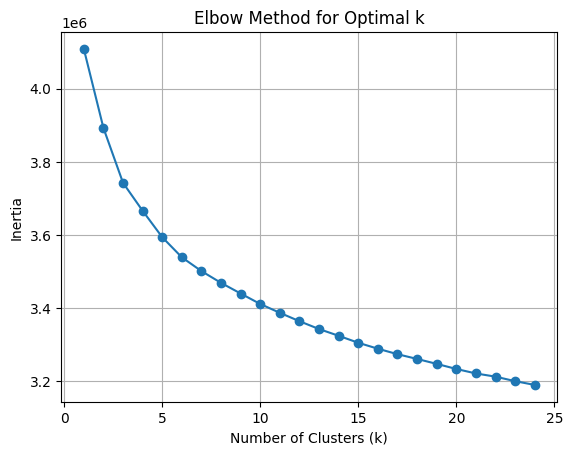

In [24]:
# Determine the optimal number of clusters using Elbow Method

inertia = []
k_range = range(1, 25)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# display the result of elbow methodplt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('elbow_plot.png')
plt.show()
plt.close()


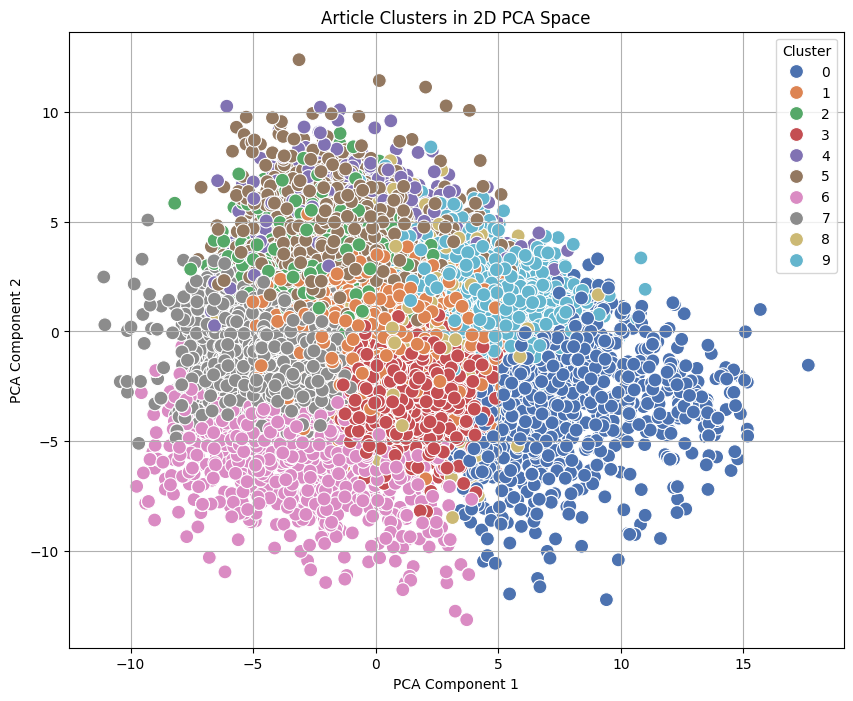

In [25]:
# Apply K-Means with optimal k (let's assume 4 based on the Elbow Method)
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_processed['cluster'] = kmeans.fit_predict(X_scaled)

# Visualizing Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_processed, x='pca_x', y='pca_y', hue='cluster', palette='deep', s=100)
plt.title('Article Clusters in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('cluster_plot.png')
plt.show()
plt.close()

## ℹ️ Visualizing Clusters with Word Clouds  (Optional Section)

### Why Use Word Clouds? 🌥️🔠  
After clustering the news articles, it’s helpful to **understand the key themes** in each cluster. A **word cloud** is a simple but effective way to visualize the most common words in each group.  

### How Does It Work? ⚙️  
1️⃣ We **extract the text** from all articles in a cluster.  
2️⃣ We **count word frequencies**, giving more importance to frequently occurring words.  
3️⃣ A **word cloud** is generated, where **larger words** indicate higher frequency in that cluster.  

### What Can We Learn? 🤔  
- Identify **dominant keywords** in each cluster.  
- Get **insights into topic differences** between clusters.  
- Verify if our **K-Means clustering makes sense** based on meaningful word groupings.  

🎯 **Goal:** Use word clouds to quickly interpret the characteristics of each news category! ☁️📰🔍  


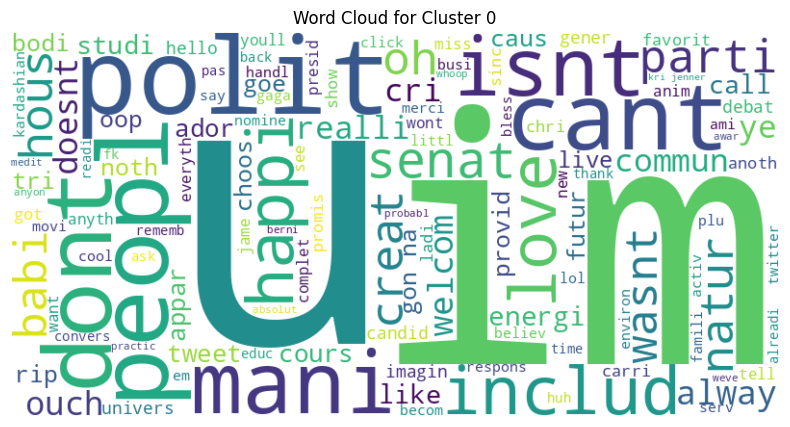

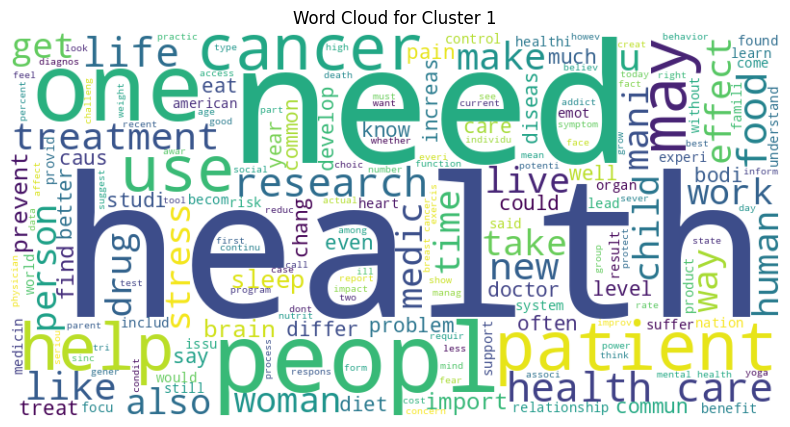

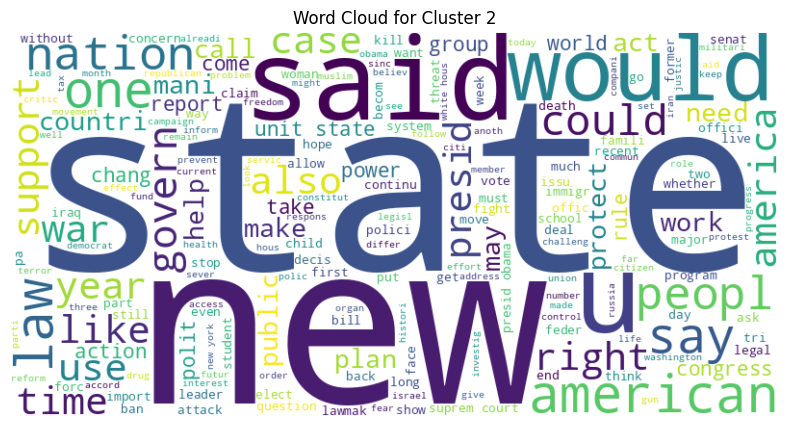

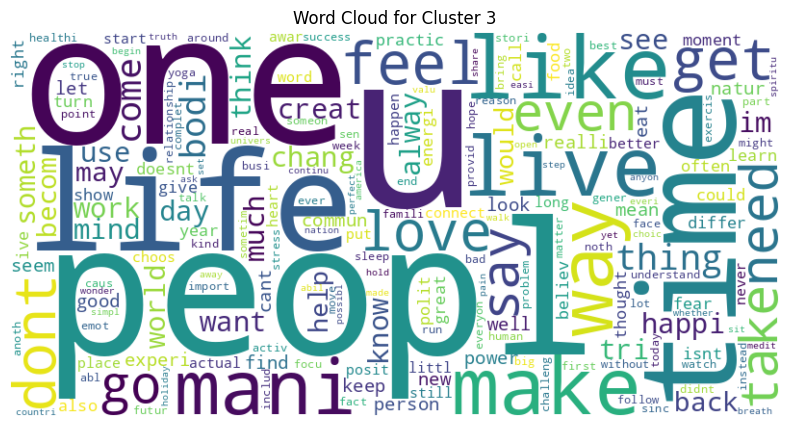

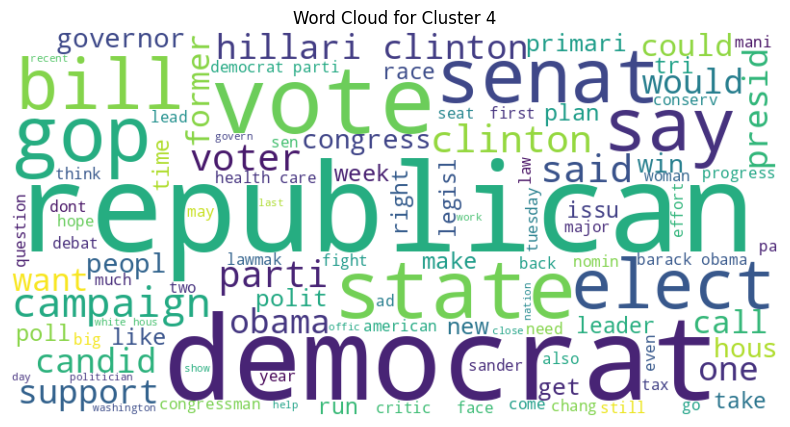

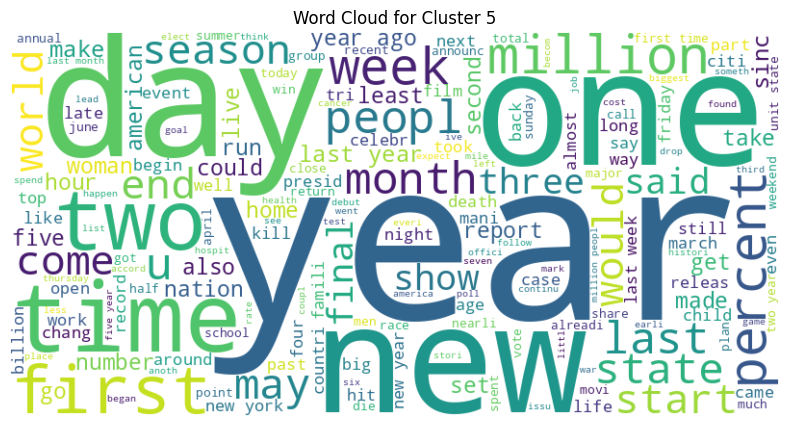

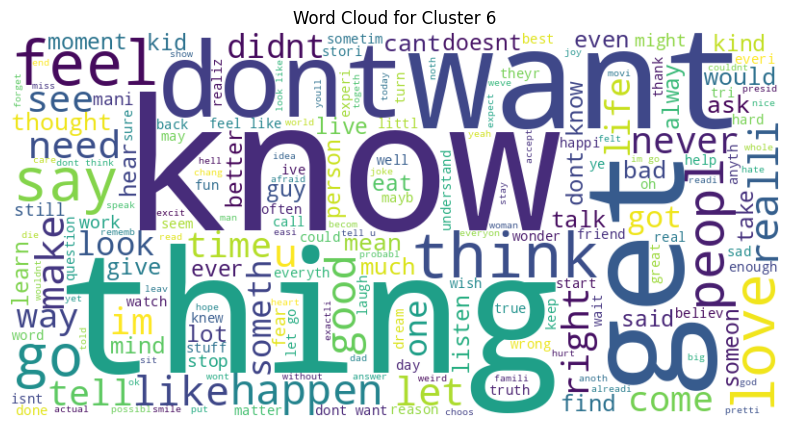

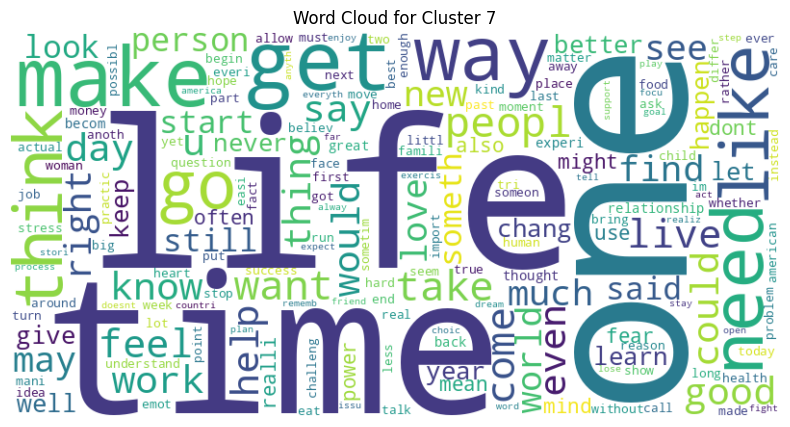

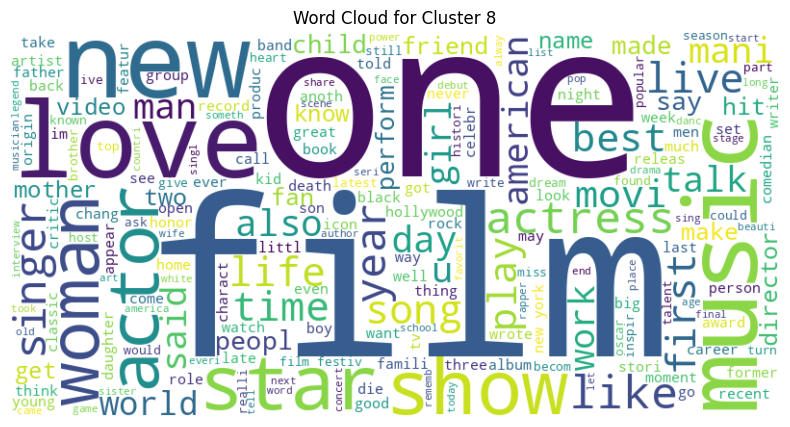

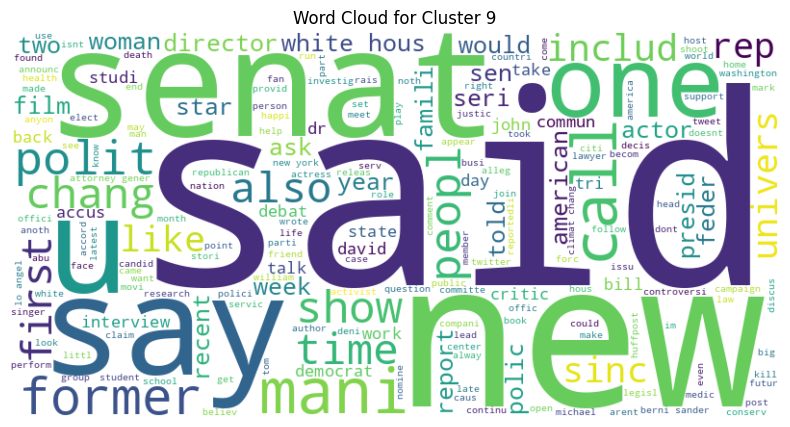

Processing complete. Check saved plots and CSV file.


In [27]:
from wordcloud import WordCloud

stop_words = set(stopwords.words('english'))

for cluster_id in range(optimal_k):
    # Getting descriptions for this cluster
    cluster_texts = df_processed[df_processed['cluster'] == cluster_id]['description']
    if cluster_texts.empty:
        continue
    # Combining all texts
    combined_text = ' '.join(cluster_texts)
    # Generating word cloud
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         stopwords=stop_words,
                         min_font_size=10).generate(combined_text)
    # Plotting word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Cluster {cluster_id}')
    plt.savefig(f'wordcloud_cluster_{cluster_id}.png')
    plt.show()
    plt.close()

df_processed.to_csv('processed_articles_with_clusters.csv', index=True)

print("Processing complete. Check saved plots and CSV file.")

🧐 Critical Thinking & Discussion: Interpreting Our Results 💡📊📰

### 1️⃣ PCA Visualization Analysis
#### 🔍 Question:
Looking at the PCA Projection of News Articles, we see that the data is spread out but still has some overlapping areas.

- What does this distribution tell us about the underlying structure of the articles?
- Do you think reducing dimensionality to 2 components sufficiently preserves the key variations in the dataset? Why or why not?


### 2️⃣ Choosing the Optimal Number of Clusters
#### 📊 Question:
The Elbow Method plot suggests a decreasing trend in distortion as k increases.

- Based on the curve, what would you choose as the optimal k value?
- Why does the distortion decrease as k increases, and why shouldn’t we always choose a very high k?

### 3️⃣ Interpreting Clusters of News Articles
#### 📰 Question:
After applying K-Means clustering, the PCA-reduced plot shows four distinct clusters.

- How well-separated do the clusters appear? Do they seem meaningful?
- What possible themes might each cluster represent in terms of news content? How could we validate our assumptions about these themes?






